In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
Rasa Khosrowshahli
June 11 2025

This module contains methods related to evaluating a chromosome in the GA

Was written as part of assignment 1 for COSC 3P71 in Spring 2025
"""
import re


def decrypt(k: str, t: str) -> str:
    """Decrypt the text (t) using key (k)

    Args:
        k (str): The key to use for decryption
        t (str): The encrypted text to decrypt

    Returns:
        str: The decrypted text
    """

    # Sanitize the cipher and the key
    cipher = t.lower()
    cipher = re.sub(r'[^a-z]', '', cipher)
    cipher = re.sub(r'\s', '', cipher)

    ke = k.lower()
    ke = re.sub(r'[^a-z]', '', ke)
    ke = re.sub(r'\s', '', ke)

    # Convert key to numpy array of integers (a=0, b=1, ..., z=25)
    key = np.array([ord(c) - 97 for c in ke], dtype=int)

    # Run the decryption
    plain = ""
    key_ptr = 0

    for i in range(len(cipher)):
        key_char = 0
        if len(key) > 0:
            # Ignore any value not in the expected range
            while key[key_ptr] > 25 or key[key_ptr] < 0:
                key_ptr = (key_ptr + 1) % len(key)
            key_char = key[key_ptr]
            key_ptr = (key_ptr + 1) % len(key)

        # Decrypt character using modular arithmetic
        decrypted_char = chr(((ord(cipher[i]) - 97 + 26 - key_char) % 26) + 97)
        plain += decrypted_char

    return plain

def encrypt(k, t):
    """Encrypt text (t) using the provided key (k) -- can use this for testing if needed

    Args:
        k (str): The key to use for encryption
        t (str): The plain text to encrypt

    Returns:
        str: The encrypted text
    """
    # Sanitize the plain text and the key
    plain = t.lower()
    plain = re.sub(r'[^a-z]', '', plain)
    plain = re.sub(r'\s', '', plain)
    cipher = ""

    ke = k.lower()
    ke = re.sub(r'[^a-z]', '', ke)
    ke = re.sub(r'\s', '', ke)

    # Convert key to numpy array of integers (a=0, b=1, ..., z=25)
    key = np.array([ord(c) - 97 for c in ke], dtype=int)

    # Encrypt the text
    key_ptr = 0
    for i in range(len(plain)):
        key_char = 0
        if len(key) > 0:
            # Ignore any value not in the expected range
            while key[key_ptr] > 25 or key[key_ptr] < 0:
                key_ptr = (key_ptr + 1) % len(key)
            key_char = key[key_ptr]
            key_ptr = (key_ptr + 1) % len(key)

        # Encrypt character using modular arithmetic
        encrypted_char = chr(((ord(plain[i]) - 97 + key_char) % 26) + 97)
        cipher += encrypted_char

    return cipher


def fitness(k, t):
    """
    This is a very simple fitness function based on the expected frequency of each letter in english
    There is lots of room for improvement in this function.

    Args:
        k (str): The key to use for decryption
        t (str): The encrypted text to decrypt

    Returns:
        float: The fitness score to be minimized
    """
    # The expected frequency of each character in english language text according to
    # http://practicalcryptography.com/cryptanalysis/letter-frequencies-various-languages/english-letter-frequencies/
    expected_frequencies = np.array([
        0.085,   # Expected frequency of a
        0.016,   # Expected frequency of b
        0.0316,  # Expected frequency of c
        0.0387,  # Expected frequency of d
        0.121,   # Expected frequency of e
        0.0218,  # Expected frequency of f
        0.0209,  # Expected frequency of g
        0.0496,  # Expected frequency of h
        0.0733,  # Expected frequency of i
        0.0022,  # Expected frequency of j
        0.0081,  # Expected frequency of k
        0.0421,  # Expected frequency of l
        0.0253,  # Expected frequency of m
        0.0717,  # Expected frequency of n
        0.0747,  # Expected frequency of o
        0.0207,  # Expected frequency of p
        0.001,   # Expected frequency of q
        0.0633,  # Expected frequency of r
        0.0673,  # Expected frequency of s
        0.0894,  # Expected frequency of t
        0.0268,  # Expected frequency of u
        0.0106,  # Expected frequency of v
        0.0183,  # Expected frequency of w
        0.0019,  # Expected frequency of x
        0.0172,  # Expected frequency of y
        0.0011   # Expected frequency of z
    ])

    # Sanitize the cipher text and key
    d = t.lower()
    d = re.sub(r'[^a-z]', '', d)
    d = re.sub(r'\s', '', d)

    # Convert cipher text to numpy array of integers
    cipher = np.array([ord(c) - 97 for c in d], dtype=int)

    ke = k.lower()
    ke = re.sub(r'[^a-z]', '', ke)
    ke = re.sub(r'\s', '', ke)

    # Convert key to numpy array of integers
    key = np.array([ord(c) - 97 for c in ke], dtype=int)

    # Initialize character counts array
    char_counts = np.zeros(26, dtype=int)

    # Decrypt each character
    plain = np.zeros(len(cipher), dtype=int)
    key_ptr = 0

    for i in range(len(cipher)):
        key_char = 0
        if len(key) > 0:
            # Ignore any value not in the expected range
            while key[key_ptr] > 25 or key[key_ptr] < 0:
                key_ptr = (key_ptr + 1) % len(key)
            key_char = key[key_ptr]
            key_ptr = (key_ptr + 1) % len(key)

        plain[i] = (26 + cipher[i] - key_char) % 26

    # Count the occurrences of each character using numpy
    for char_val in plain:
        char_counts[char_val] += 1

    # Calculate the total difference between the expected frequencies and the actual frequencies
    actual_frequencies = char_counts.astype(float) / len(plain)
    score = np.sum(np.abs(actual_frequencies - expected_frequencies))

    return score


In [3]:
def _decode_to_key(probs, maxlength=None, random_state=None):
  """
  @param probs: a transition probabilities matrix between each pair of characters in
    abcdefghijklmnopqrstuvwxyz-!
    where '-' is a padding character to ignore
      and '!' is the start character to denote the start of a sequence
      and '!' is the termination character to denote the end of a sequence
    i.e., the probs.shape should be 28 x 28
      -- whereby all characters can transit to any other character, but
        transiting from '!' must happen only at the start of the sequence
        and transiting to '!' must happen only at the end of the sequence
  """
  assert np.shape(probs) == (28, 28), "probs should be a 28x28 matrix"

  maxlength = maxlength or 1000

  rng = np.random.default_rng(random_state)

  controlcharidx = 27  # Index of '!'

  transprob = probs[controlcharidx, :]
  idx = rng.choice(np.arange(28), p=transprob)

  keylist = []

  while idx != controlcharidx and len(keylist) < maxlength:
    keylist.append(idx)
    transprob = probs[idx, :]
    idx = rng.choice(np.arange(28), p=transprob)

  return np.array(keylist)

def softmax(x):
    """
    Computes the softmax of an input array x.

    Args:
        x (np.ndarray): The input array of logits.

    Returns:
        np.ndarray: The softmax probabilities.
    """
    # Subtract the maximum value for numerical stability
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def decode_to_key(x, maxlength=None, random_state=None):
    """Fitness function for testing purposes"""
    assert np.isnan(x).sum() == 0, "x should not contain NaN values"
    transmat = softmax(x / np.linalg.norm(x, axis=1, keepdims=True))
    keyarr = _decode_to_key(transmat, maxlength=maxlength, random_state=random_state)
    alleles = "abcdefghijklmnopqrstuvwxyz-!"
    key = ''.join([alleles[i] for i in keyarr])
    return key

In [4]:
with open('../data/sample.txt', 'r') as file:
    max_keylength = int(file.readline())
    text = ''.join(line.strip() for line in file.readlines())

def f(x, random_state=None):
    key = decode_to_key(
       np.reshape(x, (28, 28)),
       maxlength=max_keylength,
       random_state=random_state)
    return fitness(key, text)


f(np.random.default_rng(24).random(28*28))

np.float64(0.7959142857142856)

In [5]:
import textwrap
print(max_keylength)
print('\n'.join(textwrap.wrap(text)))

8
xbwdesmhihslwhkktefvktkktcwfpiibihwmosfilojvooegvefwnochsuuspsureifakb
nlalzsrsroiejwzgfpjczldokrceoahzshpbdwpcjstacgbarfwifwohylckafckzwwoml
alghrtafchfetcgfpfrgxclwzocdctmjebx


In [6]:
print('\n'.join(textwrap.wrap(decrypt('password', text))))

ibelievethatattheendofthecenturytheuseofwordsandgeneraleducatedopinion
willhavealteredsomuchthatonewillbeabletospeakofmachinesthinkingwithout
expectingtobecontradictedalanturing


In [7]:
ngen = 128
popsize = 128

In [8]:
def run_es(ngen, popsize, ndim, fitfn, learning_rate=0.01, noise_factor=0.1, random_state=None):
    rng = np.random.default_rng(random_state)
    guess = rng.normal(size=ndim)
    guesses = []
    for i in range(ngen):
        N = rng.normal(size=(popsize, ndim))  # sample from normal distribution
        F = np.zeros(popsize)
        for j in range(popsize):
            w = guess + noise_factor * N[j]
            F[j] = fitfn(w)
        # standardize fitnesses to have guassian (normal) distribution
        A = (F - np.mean(F)) / np.std(F)
        guess = guess - learning_rate / (popsize * noise_factor) * np.dot(np.transpose(N), A)
        guesses.append(guess)
        if i % (ngen // 10) == 0:
            print(f"gen:{i}, fitness:{fitfn(guess):.3f}")
    return np.array(guesses)

In [9]:
runs = dict()
def fx(x, random_state=None):
    assert np.isnan(x).sum() == 0, "x should not contain NaN values"
    rng = np.random.default_rng(random_state)
    trials = [
        f(x, random_state=rng)
        for _ in range(30) # 30 trials for statistical stability
    ]
    return np.mean(trials)
for seed in range(30):
    guesses = run_es(
        ngen=ngen,
        popsize=popsize,
        ndim=28*28,
        fitfn=lambda x: fx(x, random_state=seed),
        learning_rate=0.01,
        noise_factor=0.1,
        random_state=seed)
    runs[seed] = guesses

gen:0, fitness:0.757
gen:12, fitness:0.729
gen:24, fitness:0.729
gen:36, fitness:0.725
gen:48, fitness:0.721
gen:60, fitness:0.719
gen:72, fitness:0.716
gen:84, fitness:0.712
gen:96, fitness:0.709
gen:108, fitness:0.709
gen:120, fitness:0.709
gen:0, fitness:0.741
gen:12, fitness:0.727
gen:24, fitness:0.720
gen:36, fitness:0.717
gen:48, fitness:0.715
gen:60, fitness:0.715
gen:72, fitness:0.715
gen:84, fitness:0.715
gen:96, fitness:0.715
gen:108, fitness:0.710
gen:120, fitness:0.710
gen:0, fitness:0.768
gen:12, fitness:0.742
gen:24, fitness:0.740
gen:36, fitness:0.738
gen:48, fitness:0.737
gen:60, fitness:0.735
gen:72, fitness:0.732
gen:84, fitness:0.731
gen:96, fitness:0.731
gen:108, fitness:0.731
gen:120, fitness:0.730
gen:0, fitness:0.770
gen:12, fitness:0.744
gen:24, fitness:0.726
gen:36, fitness:0.723
gen:48, fitness:0.722
gen:60, fitness:0.718
gen:72, fitness:0.714
gen:84, fitness:0.714
gen:96, fitness:0.714
gen:108, fitness:0.714
gen:120, fitness:0.709
gen:0, fitness:0.744
gen:12,

In [10]:
dfs = []
for seed, guesses in runs.items():
  df = pd.DataFrame([dict(seed=seed, gen=gen, fitness=fx(guess, random_state=gen)) for gen, guess in enumerate(guesses)])
  dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df

,seed,gen,fitness
0,0,0,0.756819
1,0,1,0.754536
2,0,2,0.771955
3,0,3,0.750717
4,0,4,0.749658
...,...,...,...
3835,29,123,0.779088
3836,29,124,0.773908
3837,29,125,0.774965
3838,29,126,0.751377


In [11]:
df.loc[df['seed']==4]

,seed,gen,fitness
512,4,0,0.751635
513,4,1,0.769885
514,4,2,0.751808
515,4,3,0.755830
516,4,4,0.743173
...,...,...,...
635,4,123,0.790590
636,4,124,0.790374
637,4,125,0.756014
638,4,126,0.788530


In [12]:
_ = df.loc[df['gen']==ngen-1]
_ = _.loc[_['fitness'] == _['fitness'].min()]

row = _
transmat = guesses[row['seed'].values[0]]
x = np.reshape(transmat, (28, 28))
x = softmax(x / np.linalg.norm(x, axis=1, keepdims=True))
with pd.option_context('display.precision', 3):
    pd.DataFrame(x * 100, index=list('abcdefghijklmnopqrstuvwxyz-!'), columns=list('abcdefghijklmnopqrstuvwxyz-!'))

In [21]:
import textwrap
for seed in range(10):
    key = decode_to_key(np.reshape(transmat, (28, 28)), maxlength=max_keylength, random_state=seed)
    print(f"{key = }")
    print('\n'.join(textwrap.wrap(decrypt(key, text))))
    print()

key = 'ribawzqu'
gtvditwnrzrlaiuqcwevouuqcuvftjshrzvmstpougivspomewewrpmnbmtsttexnaeaoc
xrjdysvtburwiwdhpvsuylhpuxlwnalacnytcwtdtycsbgfbblfaewsiirlczfgljcfgll
emqnalzfgipkcufftgbmgukwdpmjllljich

key = 'n-d-ilwl'
kyosihzeawwajeczxtssciozgzoutxvyawabbpxxpdwsgdivibxlrdpekjyhcpmgixsxcq
ranirhvhelatnlmdxenrmivdogpbgplofehqhlczbhxppdtpvujfxlswliuzeuphrladzi
sakweqsugwsblrkuccjvbrytrdgspqeyiqk

key = 'ghwcqufb'
ruaboyhgcawjgnfjnxjtuzfjnvadzodacaakyyahfhntyuzfpxjuxuxgmnyqzypqybjyuh
ikuedqbymncxnujmaodvdjnufqwxsyrfngjuhuzierntgelgmeqbjuyntkwdedmquvqhqj
krbglmedmnadnvkdzlmfrvpujuxcwmqhohs

key = 'cgwpclme'
vvaochadgbwwuwygryjgiiygrwaqnxwxgbaxmhtejingmdsctyjhldqdqoydnhinccjliq
bhyfddphfkgynhxvtlhwdwbdynayslfogdnvhhnrxorugrzpfbucjhmwmhaeeqaznsuiqw
yaudpneqawtarwkqnufcvwphxdqzanqucql

key = '-o'
jnipqeytutexitwwfqrhwfwwfoirbuunutiyaeruxavhaaqshqrizaoteggebegdqurmwn
zxmxlededauqvilsrbvolxpawdoqamtletbnpibovefmosnmdriuriatkxowmrowliiayx
mxstdfmrotrqfosrbrdsjoxilaopofyvqnj

key = 'wwoibkkb'
bfivdicgm

In [14]:
df.loc[df['gen']==ngen-1, 'fitness'].describe()

count    30.000000
mean      0.770530
std       0.011595
min       0.747161
25%       0.764079
50%       0.769945
75%       0.779241
max       0.791555
Name: fitness, dtype: float64

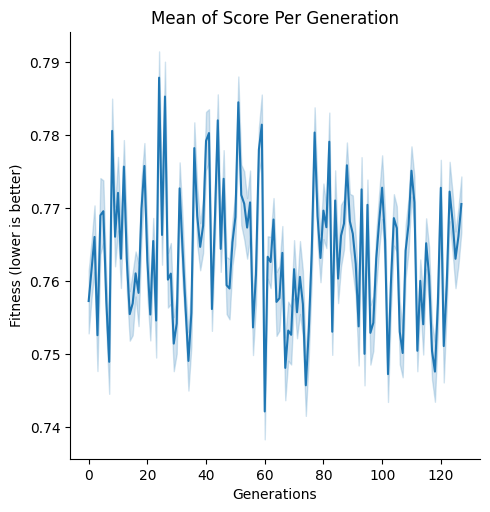

In [15]:
g = sns.relplot(data=df, x='gen', y='fitness', kind='line', errorbar='ci', estimator='mean', seed=0)
# g.set(yscale='log')
plt.title("Mean of Score Per Generation")
plt.xlabel("Generations")
plt.ylabel("Fitness (lower is better)")
plt.show()